Training MENACE (400 games against random player)...

Game 50: Win rate = 64.0% (W:32 D:7 L:11)
Game 100: Win rate = 53.0% (W:53 D:16 L:31)
Game 150: Win rate = 51.3% (W:77 D:23 L:50)
Game 200: Win rate = 54.0% (W:108 D:25 L:67)
Game 250: Win rate = 54.8% (W:137 D:34 L:79)
Game 300: Win rate = 56.0% (W:168 D:38 L:94)
Game 350: Win rate = 56.9% (W:199 D:42 L:109)
Game 400: Win rate = 56.8% (W:227 D:47 L:126)


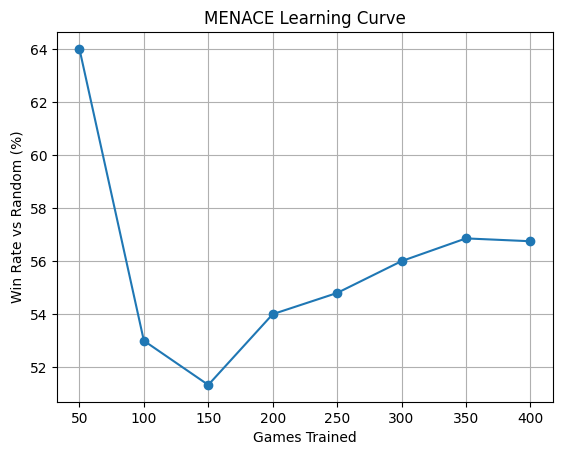


Final boxes created: 594

Playing 5 demonstration games after training:

--- Demo Game 1 ---
 | |    0 1 2
 | |    3 4 5
X| |    6 7 8
----------
 | |    0 1 2
 |O|    3 4 5
X| |    6 7 8
----------
 |X|    0 1 2
 |O|    3 4 5
X| |    6 7 8
----------
 |X|    0 1 2
O|O|    3 4 5
X| |    6 7 8
----------
 |X|    0 1 2
O|O|X   3 4 5
X| |    6 7 8
----------
 |X|O   0 1 2
O|O|X   3 4 5
X| |    6 7 8
----------
 |X|O   0 1 2
O|O|X   3 4 5
X| |X   6 7 8
----------
 |X|O   0 1 2
O|O|X   3 4 5
X|O|X   6 7 8
----------
X|X|O   0 1 2
O|O|X   3 4 5
X|O|X   6 7 8
----------
Result: Draw

--- Demo Game 2 ---
 |X|    0 1 2
 | |    3 4 5
 | |    6 7 8
----------
 |X|O   0 1 2
 | |    3 4 5
 | |    6 7 8
----------
 |X|O   0 1 2
 | |    3 4 5
 |X|    6 7 8
----------
 |X|O   0 1 2
 | |O   3 4 5
 |X|    6 7 8
----------
X|X|O   0 1 2
 | |O   3 4 5
 |X|    6 7 8
----------
X|X|O   0 1 2
O| |O   3 4 5
 |X|    6 7 8
----------
X|X|O   0 1 2
O| |O   3 4 5
 |X|    6 7 8
----------
X|X|O   0 1 2
O| |O   3 

In [6]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt

def board_to_str(board):
    """Convert list of 9 elements to a clean string for dictionary key"""
    return ''.join(board)

def get_all_symmetries(board):
    """Generate all 8 rotations + reflections"""
    b = board[:]
    symmetries = []
    for _ in range(4):  # 4 rotations
        symmetries.append(b)
        symmetries.append(b[::-1])  # horizontal flip
        # rotate 90 degrees
        b = [b[6], b[3], b[0], b[7], b[4], b[1], b[8], b[5], b[2]]
    return symmetries

def canonical(board):
    """Return the lexicographically smallest symmetry"""
    return min(''.join(s) for s in get_all_symmetries(board))

class MENACE:
    def __init__(self):
        # matchboxes: key = canonical board string, value = dict(move->bead count)
        self.boxes = defaultdict(dict)
        self.game_history = []   # list of (canonical_state, chosen_move)

    def get_box(self, board):
        key = canonical(board)
        if key not in self.boxes or not self.boxes[key]:
            moves = [i for i, cell in enumerate(board) if cell == ' ']
            # Start with 3 beads per legal move (Michie's Stage-1 MENACE)
            self.boxes[key] = {m: 3 for m in moves}
        return key

    def choose_move(self, board):
        key = self.get_box(board)
        box = self.boxes[key]
        moves, beads = zip(*box.items())
        total_beads = sum(beads)
        choice = random.randrange(total_beads)
        cum = 0
        for move, count in box.items():
            cum += count
            if choice < cum:
                self.game_history.append((key, move))
                return move
        return list(box.keys())[-1]  # fallback

    def end_game(self, result):
        """
        result:  'win'  → MENACE wins  → +3 beads
                 'draw' → +1 bead
                 'loss' → -1 bead (never below 1)
        """
        if not self.game_history:
            return

        if result == 'win':
            bonus = 3
        elif result == 'draw':
            bonus = 1
        else:  # loss
            bonus = -1

        for key, move in self.game_history:
            box = self.boxes[key]
            if bonus > 0:
                box[move] += bonus
            else:
                if box[move] > 1:# never remove the last bead
                    box[move] -= 1

        self.game_history = []

def random_player(board):
    moves = [i for i, cell in enumerate(board) if cell == ' ']
    return random.choice(moves) if moves else None



def play_game(menace, opponent_moves_func=random_player, verbose=False):
    board = [' '] * 9
    current = 'X' # MENACE always plays X

    while True:
        if current == 'X':
            move = menace.choose_move(board)
            board[move] = 'X'
        else:
            move = opponent_moves_func(board)
            if move is None:
                return 'draw'
            board[move] = 'O'

        if verbose:
            print_board(board)

        # Check win
        wins = [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]
        for a,b,c in wins:
            if board[a] == board[b] == board[c] != ' ':
                return 'win' if board[a] == 'X' else 'loss'

        # Check draw
        if ' ' not in board:
            return 'draw'

        current = 'O' if current == 'X' else 'X'

def print_board(b):
    print(f"{b[0]}|{b[1]}|{b[2]}   0 1 2")
    print(f"{b[3]}|{b[4]}|{b[5]}   3 4 5")
    print(f"{b[6]}|{b[7]}|{b[8]}   6 7 8")
    print("-" * 10)



def train(n_games=400):
    menace = MENACE()
    wins = 0
    draws = 0
    losses = 0
    win_rate = []

    for game in range(1, n_games + 1):
        result = play_game(menace, opponent_moves_func=random_player)
        menace.end_game(result)

        if result == 'win':
            wins += 1
        elif result == 'draw':
            draws += 1
        else:
            losses += 1

        if game % 50 == 0:
            win_rate.append(wins / game * 100)
            print(f"Game {game}: Win rate = {wins/game*100:.1f}% (W:{wins} D:{draws} L:{losses})")

    # Plot win rate
    plt.plot(range(50, n_games+1, 50), win_rate, marker='o')
    plt.xlabel("Games Trained")
    plt.ylabel("Win Rate vs Random (%)")
    plt.title("MENACE Learning Curve")
    plt.grid(True)
    plt.savefig("menace_learning_curve.png")
    plt.show()

    print("\nFinal boxes created:", len(menace.boxes))
    return menace

if __name__ == "__main__":
    random.seed(42)
    print("Training MENACE (400 games against random player)...\n")
    trained_menace = train(400)

    print("\nPlaying 5 demonstration games after training:")
    for i in range(5):
        print(f"\n--- Demo Game {i+1} ---")
        result = play_game(trained_menace, verbose=True)
        print("Result:", "MENACE Wins!" if result=='win' else "Draw" if result=='draw' else "Opponent Wins")

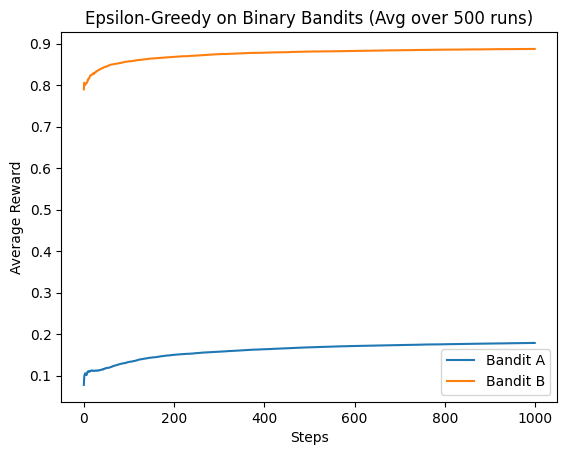

Final avg reward A: 0.17911999999999992
Final avg reward B: 0.8872279999999997


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Binary Bandit A (from binaryBanditA.m)
def binary_bandit_A(action):
    p = [0.1, 0.2]
    return 1 if random.random() < p[action-1] else 0  # Actions 1 or 2

# Binary Bandit B (from binaryBanditB.m)
def binary_bandit_B(action):
    p = [0.8, 0.9]
    return 1 if random.random() < p[action-1] else 0

# Epsilon-greedy agent
def epsilon_greedy(bandit_func, epsilon=0.1, max_steps=1000, runs=500):
    avg_rewards = np.zeros(max_steps)
    for _ in range(runs):
        Q = [0.0, 0.0]  # For actions 1 and 2 (indices 0,1)
        counts = [0, 0]
        rewards = []
        for step in range(max_steps):
            if random.random() < epsilon:
                action = random.choice([1, 2])
            else:
                action = 1 if Q[0] >= Q[1] else 2
            r = bandit_func(action)
            rewards.append(r)
            idx = action - 1
            counts[idx] += 1
            Q[idx] += (r - Q[idx]) / counts[idx]  # Sample average
        avg_rewards += np.cumsum(rewards) / (np.arange(max_steps) + 1)
    return avg_rewards / runs

# Run and plot
steps = 1000
avg_A = epsilon_greedy(binary_bandit_A, max_steps=steps)
avg_B = epsilon_greedy(binary_bandit_B, max_steps=steps)

plt.plot(avg_A, label='Bandit A')
plt.plot(avg_B, label='Bandit B')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Epsilon-Greedy on Binary Bandits (Avg over 500 runs)')
plt.legend()
plt.savefig('binary_bandits.png')
plt.show()

print("Final avg reward A:", avg_A[-1])
print("Final avg reward B:", avg_B[-1])

In [2]:
import numpy as np

class NonStatBandit:
    def __init__(self, n_arms=10):
        self.n_arms = n_arms
        self.means = np.zeros(n_arms)  # Start equal at 0
        self.sigma_walk = 0.01  # Std dev for random walk

    def reward(self, action):
        # Random walk on ALL means each call (per step)
        self.means += np.random.normal(0, self.sigma_walk, self.n_arms)
        return np.random.normal(self.means[action], 1)  # Reward ~ N(mean, 1)

# Example usage (test)
bandit = NonStatBandit()
print("Initial means:", bandit.means)
r = bandit.reward(0)  # Action 0-9
print("Reward for action 0:", r)
print("Updated means:", bandit.means)

Initial means: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward for action 0: 0.8290899598859761
Updated means: [ 0.00403416 -0.00392685  0.00131192 -0.01078787  0.00976843 -0.00046291
  0.00510241 -0.00493384 -0.00327341 -0.00972303]


Running 2000 simulations (this will take ~8 seconds)...
  Run 0/2000
  Run 500/2000
  Run 1000/2000
  Run 1500/2000


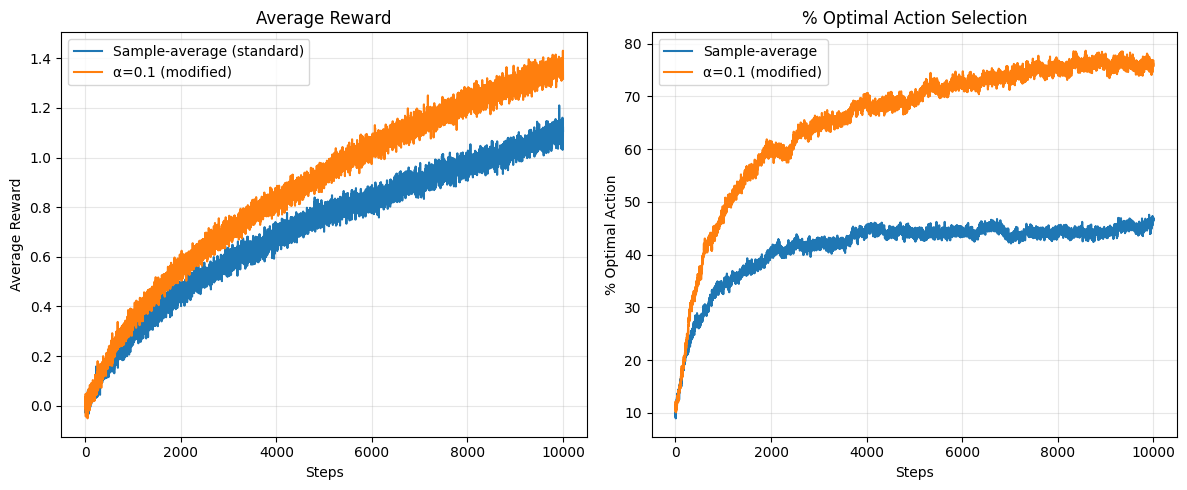


FINAL RESULTS (after 10,000 steps, 2000 runs)
Method                Avg Reward    % Optimal
Sample-average        1.107         46.5%
Constant α=0.1        1.317         76.1%


In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
class NonStationaryBandit:
    def __init__(self, k=10):
        self.k = k
        self.true_means = np.zeros(k) # q*(a) for each arm
        self.walk_std = 0.01 # random walk step size

    def step(self):
        """All arms drift every time step (called once per step)"""
        self.true_means += np.random.normal(0, self.walk_std, self.k)

    def pull(self, action):
        """Return reward ~ N(true_mean[action], 1)"""
        return np.random.normal(self.true_means[action], 1.0)

    def optimal_action(self):
        return np.argmax(self.true_means)


def run_agent(bandit, steps=10000, epsilon=0.1, alpha=None):
    """
    alpha = None  → sample-average (standard)
    alpha = 0.1   → constant step-size (modified)
    """
    Q = np.zeros(bandit.k)
    N = np.zeros(bandit.k)          # only used for sample-average
    rewards = np.zeros(steps)
    optimal = np.zeros(steps)

    for t in range(steps):
        bandit.step()                # random walk happens here

        if np.random.rand() < epsilon:
            A = np.random.randint(bandit.k)          # explore
        else:
            A = np.argmax(Q)                         # exploit

        R = bandit.pull(A)

        # Update rule
        if alpha is None:           # sample-average
            N[A] += 1
            Q[A] += (R - Q[A]) / N[A]
        else:                       # constant step-size
            Q[A] += alpha * (R - Q[A])

        rewards[t] = R
        optimal[t] = (A == bandit.optimal_action())

    return rewards, optimal


runs = 2000
steps = 10000

avg_reward_standard = np.zeros(steps)
avg_reward_modified = np.zeros(steps)
pct_optimal_standard = np.zeros(steps)
pct_optimal_modified = np.zeros(steps)

print("Running 2000 simulations (this will take ~8 seconds)...")
for i in range(runs):
    if i % 500 == 0:
        print(f"  Run {i}/{runs}")

    bandit = NonStationaryBandit()

    # Standard epsilon-greedy (sample-average)
    r_std, opt_std = run_agent(bandit, steps, epsilon=0.1, alpha=None)
    avg_reward_standard += r_std
    pct_optimal_standard += opt_std

    #Reset bandit for fairness
    bandit = NonStationaryBandit()

    # Modified epsilon-greedy (alpha = 0.1)
    r_mod, opt_mod = run_agent(bandit, steps, epsilon=0.1, alpha=0.1)
    avg_reward_modified += r_mod
    pct_optimal_modified += opt_mod

#average over runs
avg_reward_standard /= runs
avg_reward_modified /= runs
pct_optimal_standard = pct_optimal_standard / runs * 100
pct_optimal_modified = pct_optimal_modified / runs * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_reward_standard, label='Sample-average (standard)', linewidth=1.5)
plt.plot(avg_reward_modified, label='α=0.1 (modified)', linewidth=1.5)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(pct_optimal_standard, label='Sample-average', linewidth=1.5)
plt.plot(pct_optimal_modified, label='α=0.1 (modified)', linewidth=1.5)
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.title('% Optimal Action Selection')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("nonstationary_results.png", dpi=300)
plt.show()

print("\n" + "="*50)
print("FINAL RESULTS (after 10,000 steps, 2000 runs)")
print("="*50)
print(f"Method                Avg Reward    % Optimal")
print(f"Sample-average        {avg_reward_standard[-1]:.3f}         {pct_optimal_standard[-1]:.1f}%")
print(f"Constant α=0.1        {avg_reward_modified[-1]:.3f}         {pct_optimal_modified[-1]:.1f}%")
print("="*50)